In [1]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths


import sys, os
sys.path.append(os.path.abspath('../..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

# plt.rcParams['lines.linewidth'] = 0.5 



In [2]:

# Machine learning libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [619]:
pair = 'ALGO_USDT'
timeframe = '4h'

exchange = 'binance'
odf = pd.read_json(f'../../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.head(4)

(8647, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2019-06-22 00:00:00,1561161600000,3.400,3.440,2.530,2.554,4547615.806
2019-06-22 04:00:00,1561176000000,2.543,2.649,2.434,2.510,2293679.139
2019-06-22 08:00:00,1561190400000,2.510,2.570,2.439,2.543,1204777.332
2019-06-22 12:00:00,1561204800000,2.542,2.548,2.080,2.182,2867091.545


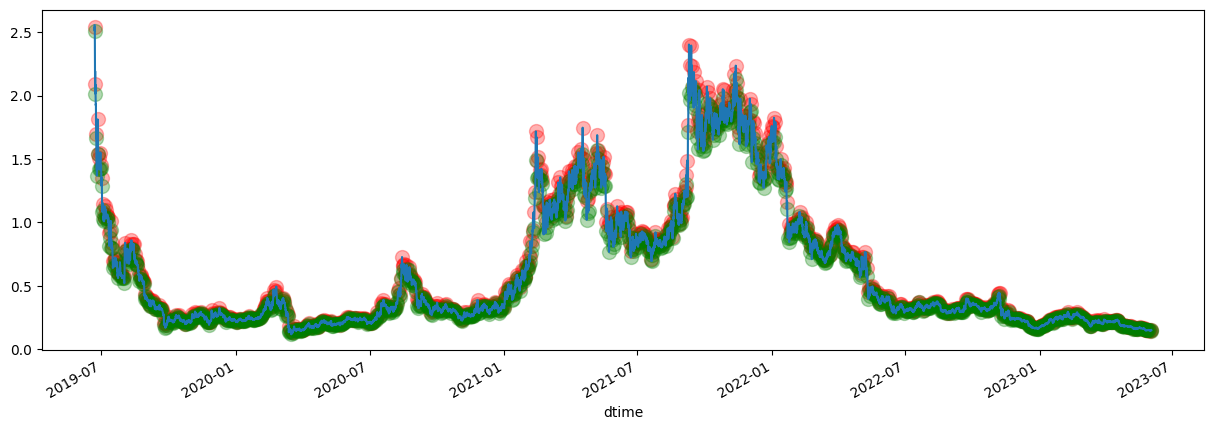

In [621]:

wdf = odf[:].copy()
wdf['bod'] = wdf[['open', 'close']].min(axis=1)
wdf['bou'] = wdf[['open', 'close']].max(axis=1)
peak_dist = 5
i_upeaks, _ = find_peaks(wdf.close, distance=peak_dist)
ix_upeaks = wdf.index[i_upeaks]
i_dpeaks, _ = find_peaks(-wdf.close, distance=peak_dist)
ix_dpeaks = wdf.index[i_dpeaks]

# wdf['']

plt.figure(figsize=(15,5))
ax1 = wdf.close.plot()
ax1.scatter(ix_upeaks, wdf.loc[ix_upeaks].close, c='r', alpha=0.3, s=100)
ax1.scatter(ix_dpeaks, wdf.loc[ix_dpeaks].close, c='g', alpha=0.3, s=100)

In [622]:
# wdf = odf[:].copy()

wdf['inow'] = range(wdf.shape[0])
wdf['lret'] = wdf.close.divide(wdf.close.shift()).apply(np.log)
a_last_peaks = np.array([
    # wdf.index.values[[idf, ipk]]
    [idf, ipk, *wdf.index[[idf, ipk]]]
    # [(idf, ipk), tuple(wdf.index[[idf, ipk]])]
    for ipk in i_upeaks

    for idf in list(range(ipk + 1, min(wdf.shape[0] - 1, ipk + 1 + int(peak_dist/2))))
]).T
wdf.loc[a_last_peaks[2],'iupk'] = a_last_peaks[1]
wdf.loc[a_last_peaks[2],'ixupk'] = a_last_peaks[3]

wdf.loc[a_last_peaks[2],'n_upk'] = wdf.loc[a_last_peaks[2],'inow'] - a_last_peaks[1]

wdf.loc[a_last_peaks[2], 'upk_close'] = wdf.loc[a_last_peaks[3]].close.values
wdf.loc[a_last_peaks[2], 'upk_ret'] = wdf.loc[a_last_peaks[2], 'close'] / wdf.loc[a_last_peaks[2], 'upk_close']  - 1
# wdf[['upk_ret']].describe()

fus = [1,2,3,4,5,6]
furet_cols = [f'furet_{fu}' for fu in fus]
# a_last_peaks[[1,3]]

wdf = wdf.join(pd.concat([ wdf.close.shift(-fu) / wdf.close - 1 for fu in fus ], axis=1).set_axis(furet_cols, axis=1)
               )

lags = [2,3,4,6]
la_cols = [f'bod_std_{la}' for la in lags]

wdf = wdf.join(pd.concat([
    wdf.bod.rolling(la).std()
    for la in lags
    ],axis=1).set_axis(la_cols, axis=1))

# wdf.fillna(0)
wdf

,timestamp,open,high,low,close,volume,bod,bou,inow,lret,...,furet_1,furet_2,furet_3,furet_4,furet_5,furet_6,bod_std_2,bod_std_3,bod_std_4,bod_std_6
dtime,,,,,,,,,,,,,,,,,,,,,
2019-06-22 00:00:00,1561161600000,3.4000,3.4400,2.5300,2.5540,4547615.806,2.5540,3.4000,0,NaN,...,-0.017228,-0.004307,-0.145654,-0.180110,-0.141738,-0.211042,NaN,NaN,NaN,NaN
2019-06-22 04:00:00,1561176000000,2.5430,2.6490,2.4340,2.5100,2293679.139,2.5100,2.5430,1,-0.017378,...,0.013147,-0.130677,-0.165737,-0.126693,-0.197211,-0.168526,0.031113,NaN,NaN,NaN
2019-06-22 08:00:00,1561190400000,2.5100,2.5700,2.4390,2.5430,1204777.332,2.5100,2.5430,2,0.013062,...,-0.141958,-0.176563,-0.138026,-0.207629,-0.179316,-0.212348,0.000000,0.025403,NaN,NaN
2019-06-22 12:00:00,1561204800000,2.5420,2.5480,2.0800,2.1820,2867091.545,2.1820,2.5420,3,-0.153103,...,-0.040330,0.004583,-0.076535,-0.043538,-0.082035,-0.095325,0.231931,0.189371,0.172584,NaN
2019-06-22 16:00:00,1561219200000,2.1910,2.2370,1.8800,2.0940,3835745.745,2.0940,2.1910,4,-0.041166,...,0.046800,-0.037727,-0.003343,-0.043457,-0.057307,-0.081662,0.062225,0.219235,0.217758,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01 16:00:00,1685635200000,0.1470,0.1481,0.1465,0.1474,3903618.000,0.1470,0.1474,8642,0.002037,...,0.005427,0.019674,0.018996,0.024423,NaN,NaN,0.000071,0.000896,0.000896,0.000806
2023-06-01 20:00:00,1685649600000,0.1474,0.1486,0.1474,0.1482,2838286.000,0.1474,0.1482,8643,0.005413,...,0.014170,0.013495,0.018893,NaN,NaN,NaN,0.000283,0.000265,0.000877,0.000907
2023-06-02 00:00:00,1685664000000,0.1482,0.1503,0.1467,0.1503,4575654.000,0.1482,0.1503,8644,0.014071,...,-0.000665,0.004657,NaN,NaN,NaN,NaN,0.000566,0.000611,0.000591,0.001118


In [623]:
wdf.columns


Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'bod', 'bou',
       'inow', 'lret', 'iupk', 'ixupk', 'n_upk', 'upk_close', 'upk_ret',
       'furet_1', 'furet_2', 'furet_3', 'furet_4', 'furet_5', 'furet_6',
       'bod_std_2', 'bod_std_3', 'bod_std_4', 'bod_std_6'],
      dtype='object')

In [667]:
tdf = wdf.dropna().copy()

X = tdf[['upk_ret', 'n_upk', 'bod_std_6', 'bod_std_3', 'bod_std_2' ] ]

y = np.where(tdf['furet_3'] < 0 , -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.5)

# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=25)

# fit the model
knn.fit(X_train, y_train)

# Accuracy Score
accuracy_train = accuracy_score(y_train, knn.predict(X_train))
accuracy_test = accuracy_score(y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.62
Test_data Accuracy: 0.55


In [668]:
X.shape, tdf.shape, wdf.shape

((2362, 5), (2362, 25), (8647, 25))

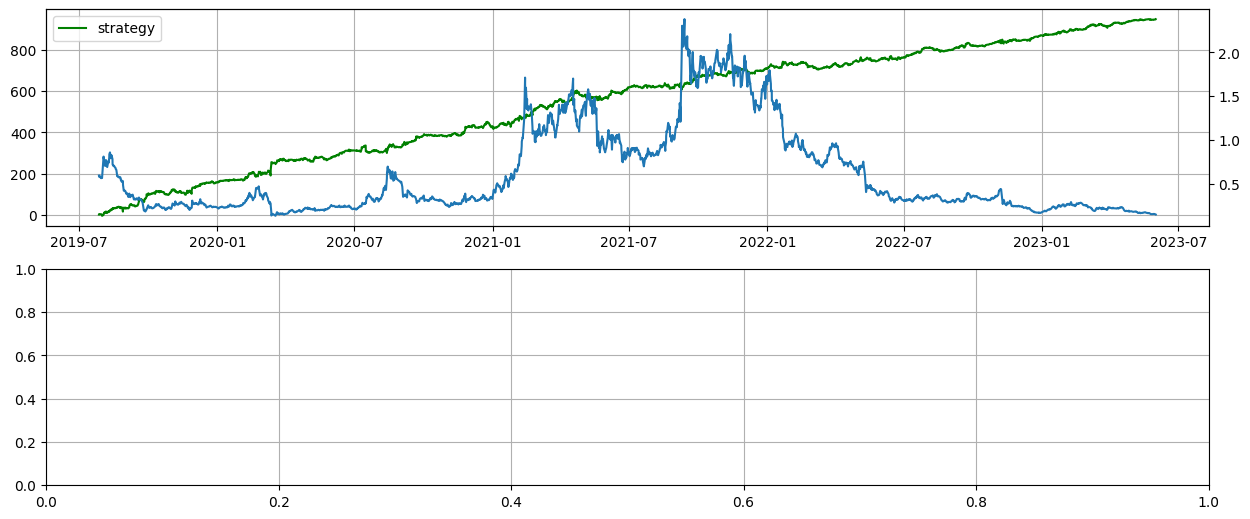

In [674]:
# Predicted Signal

y_hat = knn.predict(X)
# y_hat = y_hat[y_hat < 0]
tdf['y_hat'] = y_hat

start =  X_train.index[0]
# start =  X.index[0]
# SPY Cumulative Returns
Cumulative_Asset_returns = tdf[start:]['lret'].cumsum()

# Cumulative Strategy Returns 
tdf['strategy'] = (tdf['furet_2'] - 0.002) * (tdf['y_hat'] )#.shift(1)
Cumulative_Strategy_returns = tdf[start:]['strategy'].cumsum() * 100

# Plot the results to visualize the performance

fig = plt.figure(figsize=(15,7))
ax1, ax2 = fig.subplots(2,1)
for ax in [ax1,ax2]: ax.grid()

# plt.axvline(X_test.index[0])
# ax1.plot(Cumulative_Asset_returns.iloc[:], color='r',label = 'asset')
ax1.plot(Cumulative_Strategy_returns.iloc[:], color='g', label = 'strategy')
ax1tw = ax1.twinx()
tdf[start:].close.plot(ax=ax1tw)
# plot_candles(tdf[start:], ax=ax1tw)
ax1.legend()

# ax1tw.set_yscale('log')

plt.show()

In [660]:
len(X_test), len(tdf)

(1772, 2362)

In [640]:
X_train.tail(5), X_test.head(5)

(                      upk_ret n_upk  bod_std_6  bod_std_3  bod_std_2
 dtime                                                               
 2021-03-12 16:00:00 -0.080335     2   0.014675   0.021420   0.026304
 2022-05-07 00:00:00 -0.019974     2   0.026313   0.024969   0.007354
 2020-09-29 16:00:00 -0.034361     2   0.002884   0.003190   0.000424
 2020-11-14 04:00:00 -0.033904     2   0.004486   0.003669   0.003041
 2022-03-22 16:00:00 -0.037469     2   0.010448   0.005369   0.007425,
                       upk_ret n_upk  bod_std_6  bod_std_3  bod_std_2
 dtime                                                               
 2022-05-21 20:00:00 -0.006849     2   0.002918   0.002944   0.000000
 2022-11-01 20:00:00 -0.000832     1   0.002806   0.002801   0.003465
 2022-10-20 12:00:00 -0.001599     1   0.003813   0.003407   0.000636
 2022-03-21 00:00:00 -0.004566     2   0.011272   0.000361   0.000141
 2021-09-09 20:00:00 -0.040926     1   0.159071   0.160417   0.014284)